In [52]:
import numpy as np
import pandas as pd
from plotnine import * 

In [ ]:
desired_state = 3

ar = np.genfromtxt('../data/A/combined_traces/10uM_idl.csv', delimiter=',')

In [86]:
class PopData:
    def __init__(self, idealization_csv, exp_time = 0.1, target_fret_state = 3, photobleach_thresh=0.10):
        self.exp_time = exp_time
        self.arr_idl = np.genfromtxt(idealization_csv, delimiter=',')
        
        self.arr_target_state = np.where(self.arr_idl == target_fret_state, 1, 0)
        self.N_target_state = self.arr_target_state.sum(axis=0)
        
        self.arr_any_state = np.where(self.arr_idl >= 2, 1, 0)
        self.N_any_state = self.arr_any_state.sum(axis=0)
        
        self.N_traces = self.N_any_state.max()
        subset_ = np.where(self.N_any_state > photobleach_thresh * self.N_traces)
        
        # Shorten traces
        self.N_target_state = self.N_target_state[subset_]
        self.N_any_state = self.N_any_state[subset_]

        # Calculate state occupancy
        self.data = pd.DataFrame(columns=['i', 'C', 'time', 'state_occupancy'])
        self.data.state_occupancy = self.N_target_state / self.N_any_state
        self.data.time = np.arange(0, len(self.data)) * exp_time
    
    def gglayer(self):
        return [
            geom_line(aes(x = 'time', y = 'state_occupancy'), data=self.data),
            xlab("Time, s"),
            ylab("State occupancy"),
        ]

    def ggplot(self):
        plot = ggplot()
        for layer in self.gglayer():
            plot += layer
        return plot

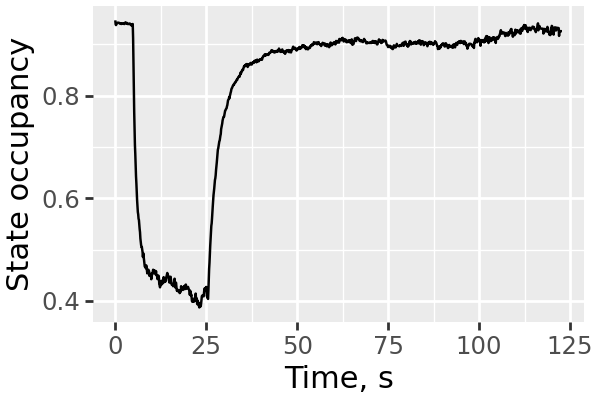

In [90]:
d = PopData('../data/A/combined_traces/10uM_idl.csv')
            
d.ggplot() + theme(figure_size=(3,2))

In [74]:
d.data

,time,state_occupancy
0,0.0,0.947030
1,0.1,0.939329
2,0.2,0.937799
3,0.3,0.939362
4,0.4,0.940426
...,...,...
1224,122.4,0.925926
1225,122.5,0.925926
1226,122.6,0.925926
1227,122.7,0.925926


,i,C,time,state_occupancy
0,NaN,NaN,15,NaN
1,NaN,NaN,16,NaN
